devoloping PCA algorithm for dimension reduction

2025-04-14 22:37:53.561316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 22:37:53.576814: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 22:37:53.695060: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 22:37:53.796742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744650473.904845  131406 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744650473.93


Processing feature type: pixel_intensity
Loading cached PCA results for pixel_intensity from cache/pca_pixel_intensity_2_components.pkl...


Loading PCA results for pixel_intensity: 100%|██████████| 1/1 [00:00<00:00, 81.97file/s]
/tmp/ipykernel_131406/1328009292.py:280: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
/tmp/ipykernel_131406/1328009292.py:291: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


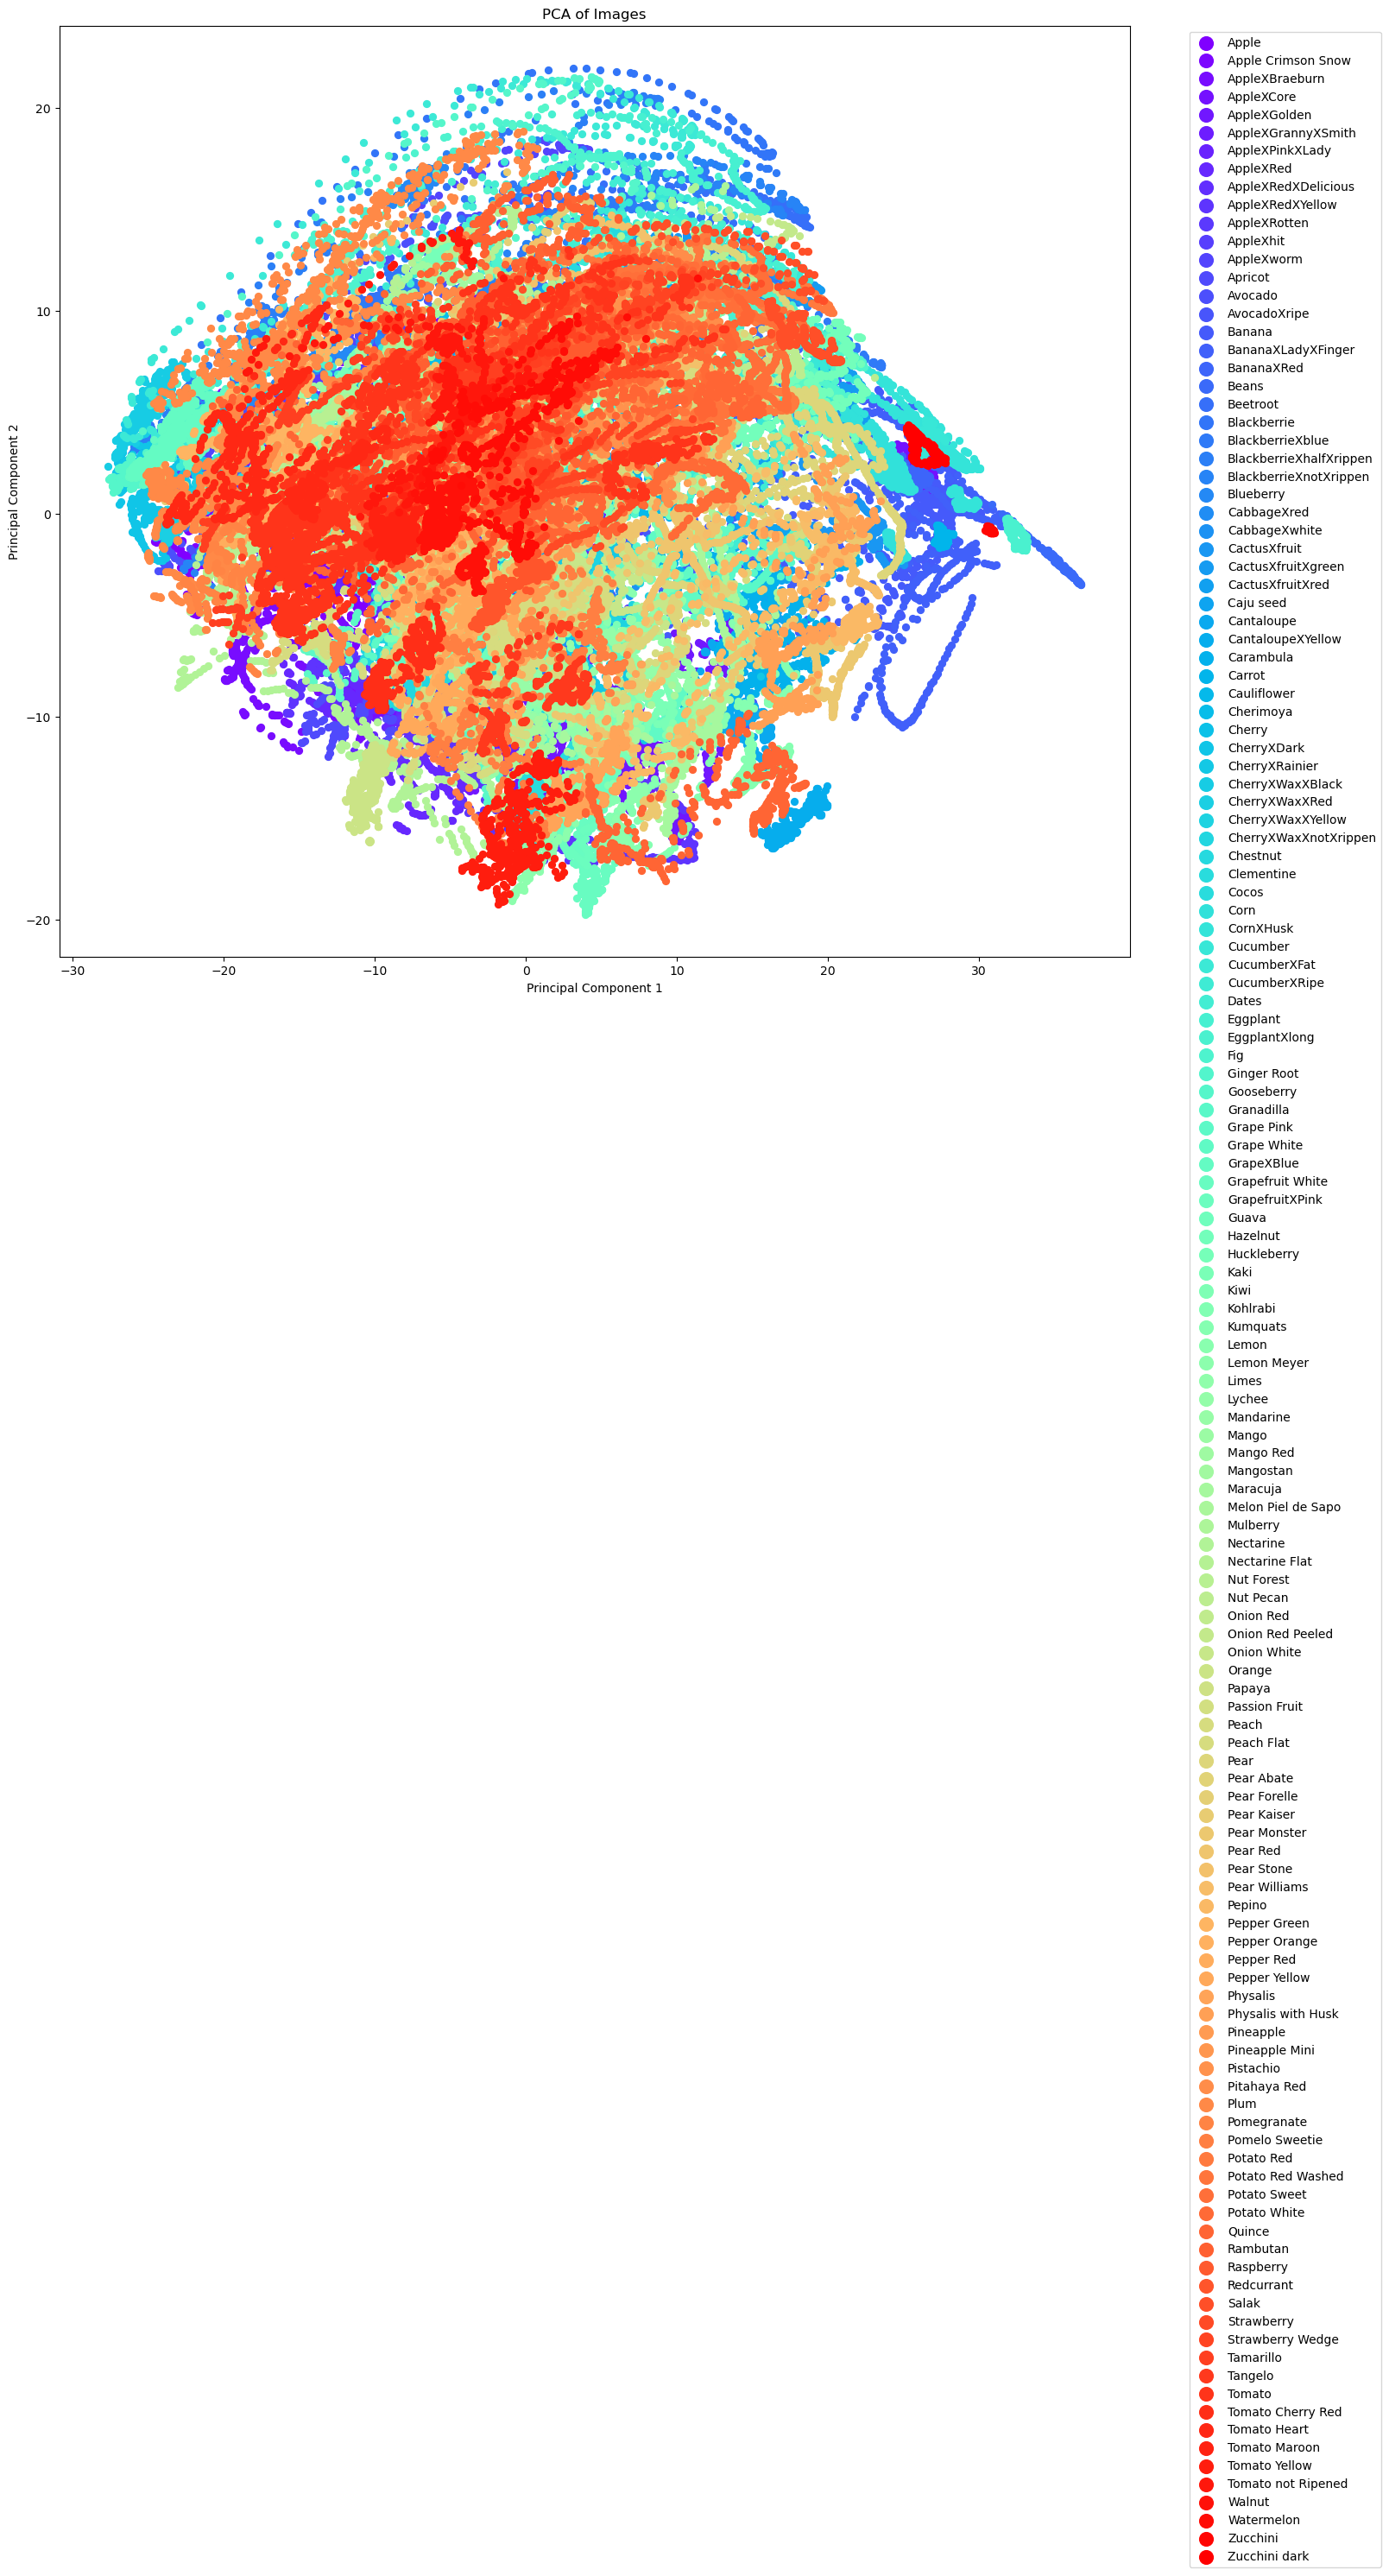


Processing feature type: color_histogram
Loading cached PCA results for color_histogram from cache/pca_color_histogram_2_components.pkl...


Loading PCA results for color_histogram: 100%|██████████| 1/1 [00:00<00:00, 92.32file/s]


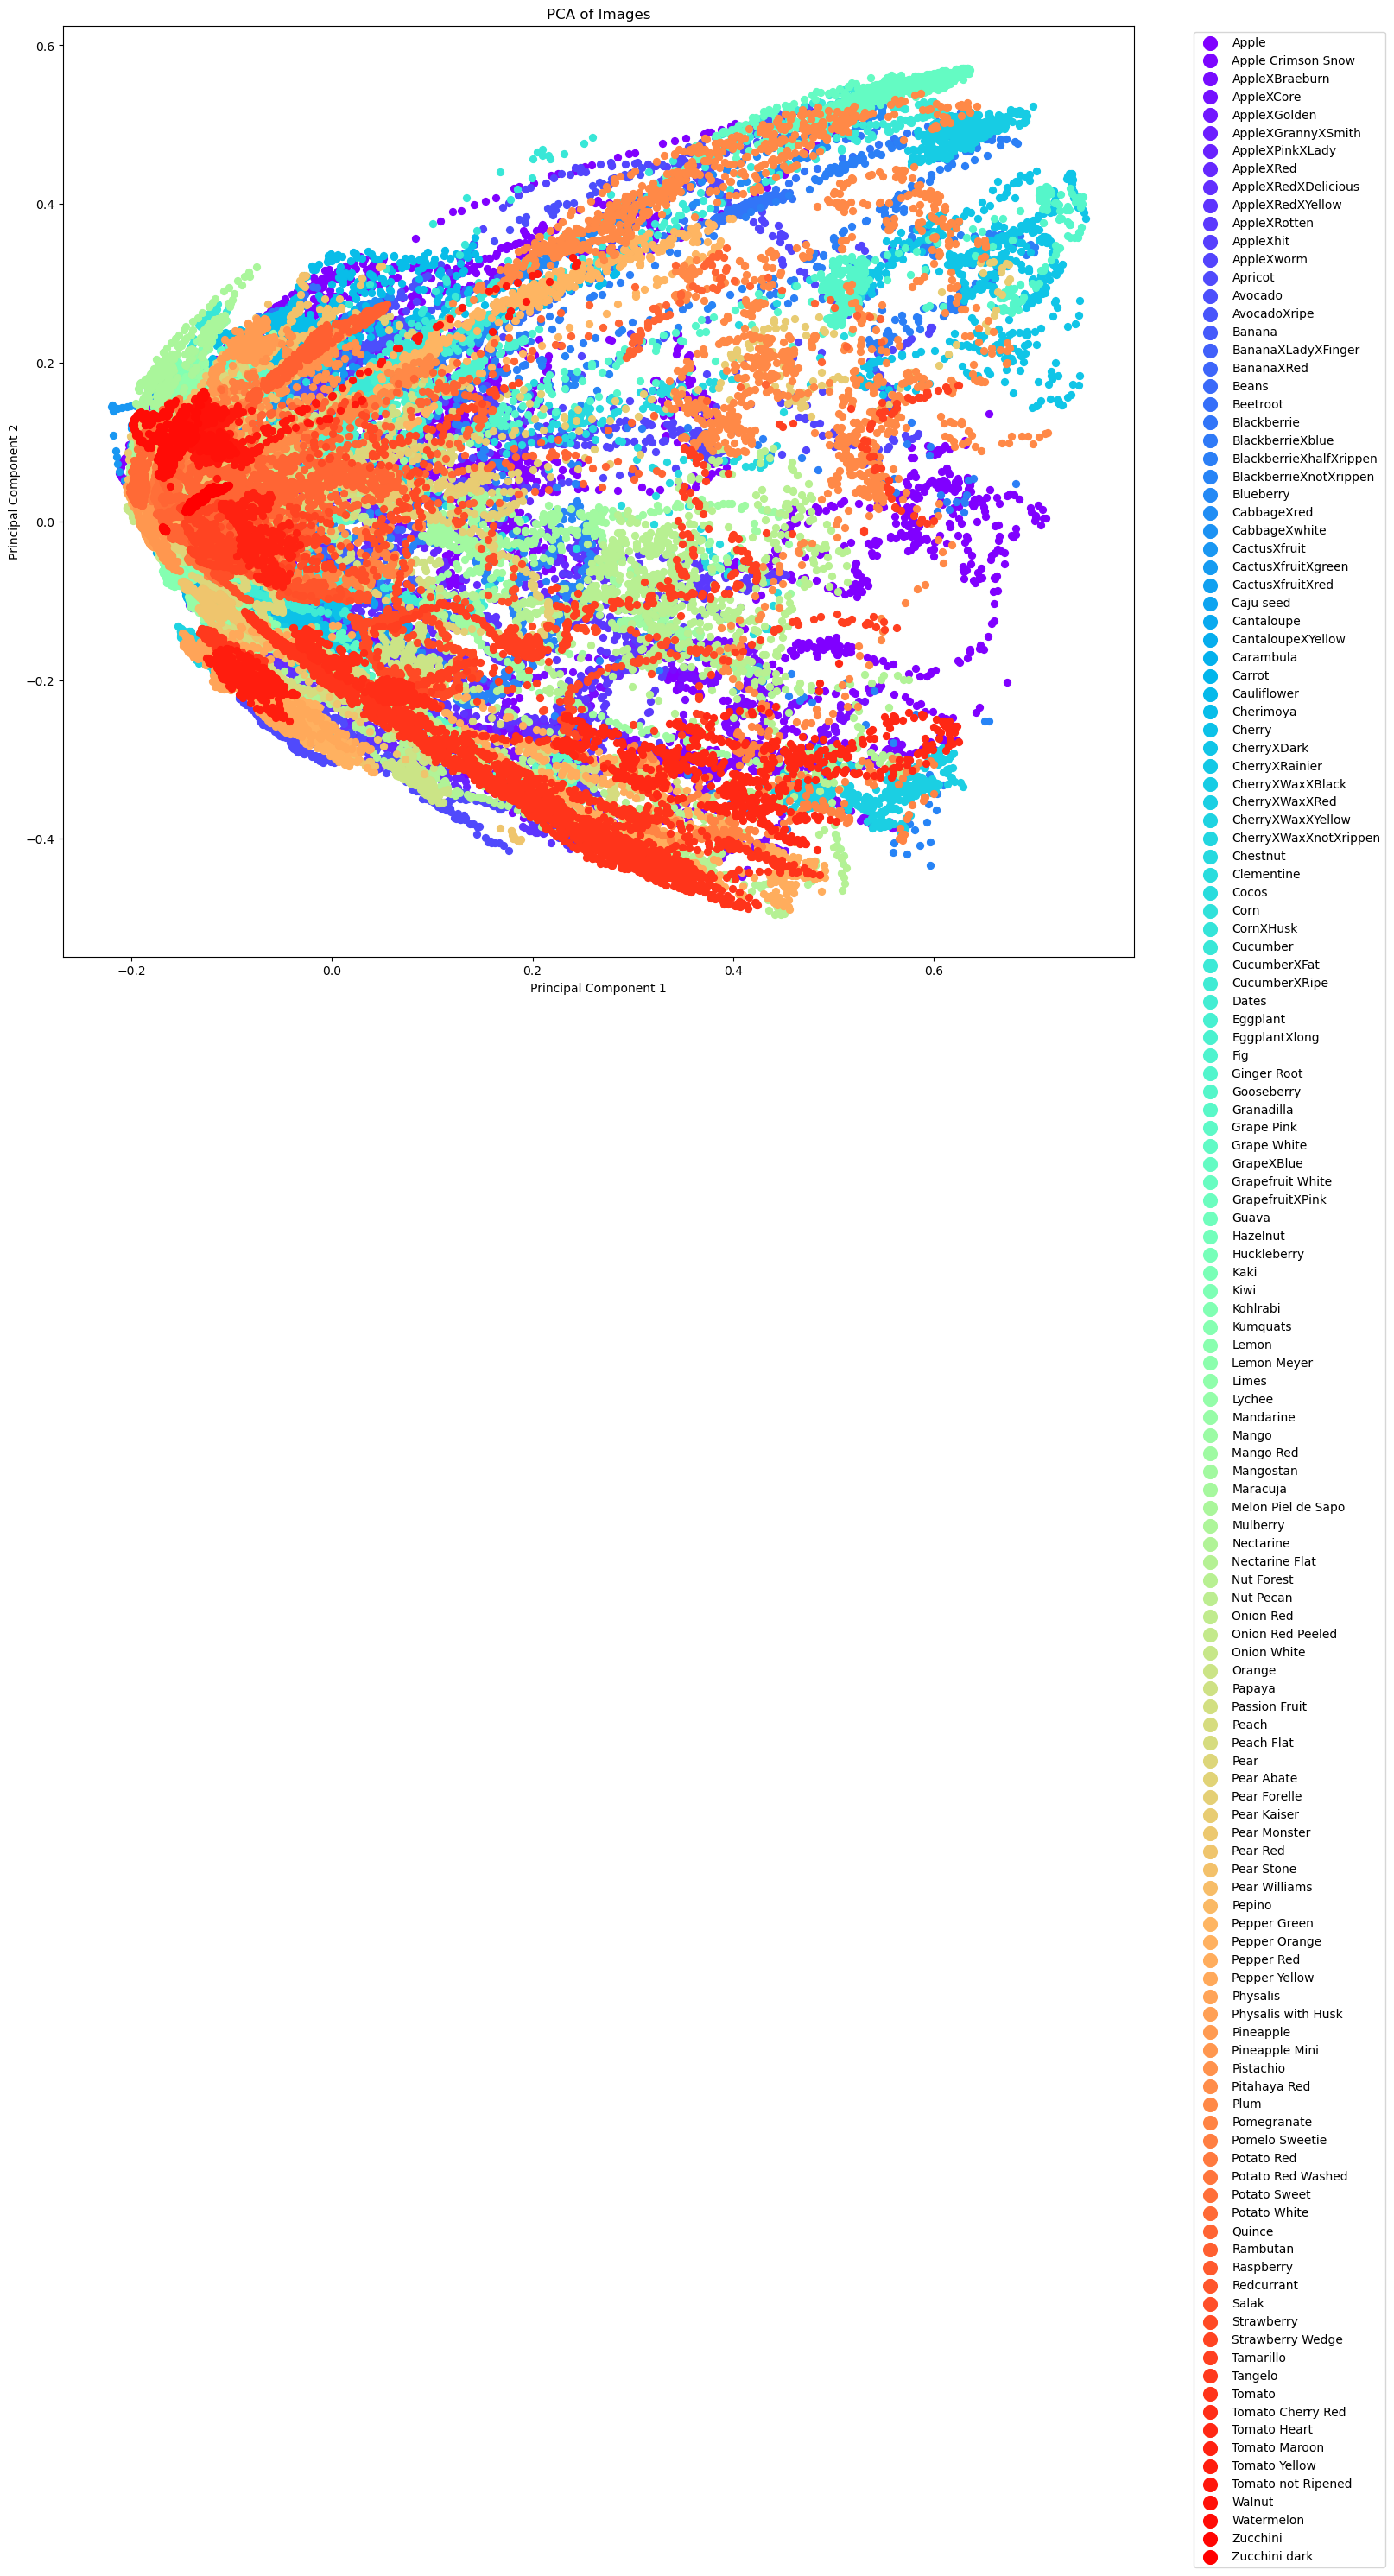


Processing feature type: hog
Loading cached PCA results for hog from cache/pca_hog_2_components.pkl...


Loading PCA results for hog: 100%|██████████| 1/1 [00:00<00:00, 52.90file/s]


KeyboardInterrupt: 

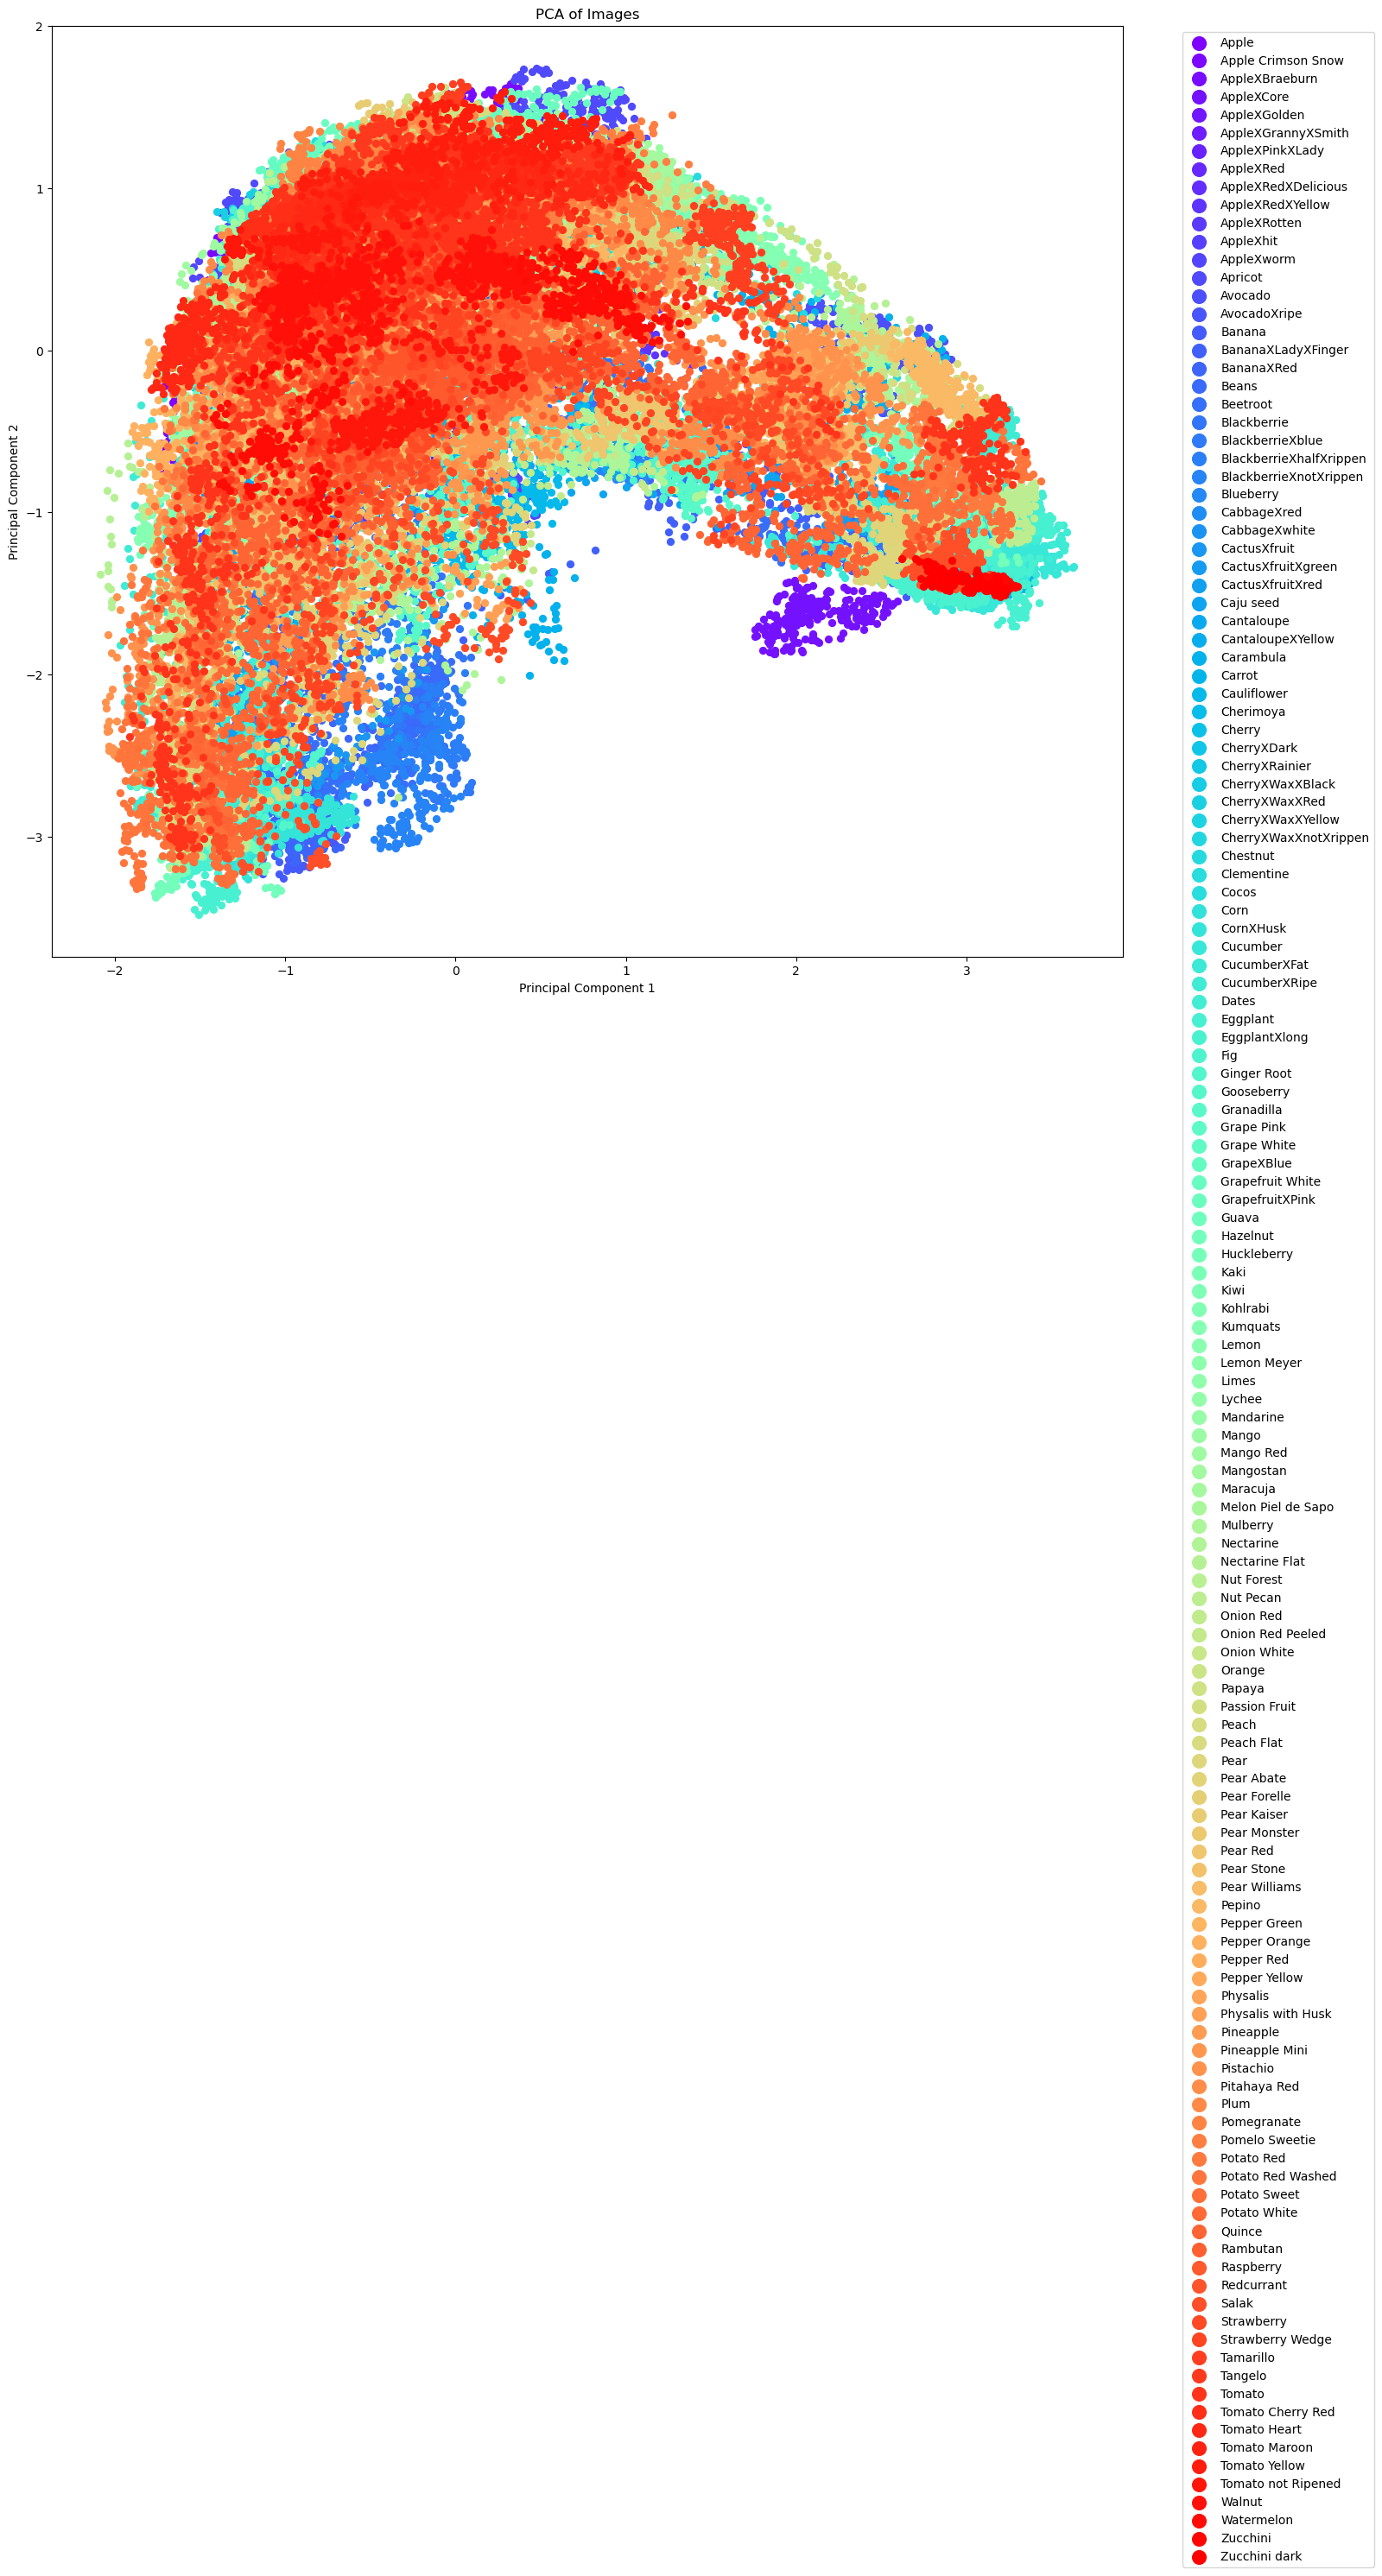

In [1]:
# --- Install required packages if not already installed ---
import subprocess
import sys

def install_if_needed(packages):
    for import_name, install_name in packages:
        try:
            __import__(import_name)
        except ImportError:
            print(f"Installing {install_name}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])

required_packages = [
    ("cv2", "opencv-python"),
    ("numpy", "numpy==1.26.4"),  # Downgrade to compatible version
    ("matplotlib", "matplotlib"),
    ("sklearn", "scikit-learn"),
    ("tqdm", "tqdm"),
    ("skimage", "scikit-image"),
    ("tensorflow", "tensorflow"),
]

install_if_needed(required_packages)


import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from os.path import isfile, join
import os
import pickle  # For saving/loading processed data
from tqdm import tqdm  # For progress bars
from skimage.feature import hog
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from skimage import exposure

# Load VGG16 without top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)


# Ensure the required libraries are installed
try:
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import IncrementalPCA
    from tqdm import tqdm
    from skimage.feature import hog
    from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
    from tensorflow.keras.models import Model
    from skimage import exposure
except ImportError as e:
    print(f"Error: {e}. Please install the required libraries.")
    exit(1)
# Define a directory to store cached data
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)  # Ensure the cache directory exists

def extract_color_histogram(image, bins=8):
    """
    Extracts a color histogram from the image.
    Args:
        image (np.ndarray): Input image.
        bins (int): Number of bins for the histogram.
    Returns:
        np.ndarray: Color histogram features.
    """
    hist = cv2.calcHist([image], [0, 1, 2], None, [bins]*3, [0, 256]*3)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hog_features(image):
    """
    Extracts HOG features from the image.
    Args:
        image (np.ndarray): Input image.
    Returns:
        np.ndarray: HOG features.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    return features

def extract_cnn_features(image):
    """
    Extracts CNN features from the image using a pre-trained VGG16 model.
    Args:
        image (np.ndarray): Input image.
    Returns:
        np.ndarray: CNN features.
    """
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image)
    return features.flatten()

# Function to import images in batches
def import_images_in_batches(path, resize_dim=(50, 50), batch_size=1000, feature_type='pixel_intensity'):
    """
    Imports images from the specified directory in batches and extracts the specified features.
    If a cache file exists, it loads the cached data instead of reprocessing the images.

    Args:
        path (str): Path to the directory containing image folders.
        resize_dim (tuple): Dimensions to resize the images (default: 50x50).
        batch_size (int): Number of images to process in each batch.
        feature_type (str): Type of features to extract ('pixel_intensity', 'color_histogram', 'hog', 'cnn').

    Yields:
        tuple: A batch of images and their corresponding labels.
    """
    # Define the cache file name based on the resize dimensions and feature type
    cache_file = join(CACHE_DIR, f"images_{feature_type}_{resize_dim[0]}x{resize_dim[1]}.pkl")
    
    # Check if the cache file exists
    if isfile(cache_file):
        try:
            print(f"Loading cached {feature_type} features from {cache_file}...")
            # Load cached images and labels with a progress bar
            with tqdm(total=1, desc=f"Loading cached {feature_type} features", unit="file") as pbar:
                with open(cache_file, "rb") as f:
                    images, labels = pickle.load(f)
                pbar.update(1)
        except (EOFError, pickle.UnpicklingError):
            # Handle corrupted cache files
            print(f"Corrupted cache file detected: {cache_file}. Deleting it...")
            os.remove(cache_file)
            raise RuntimeError("Cache file was corrupted and has been deleted. Please rerun the script.")
        
        # Yield batches of images and labels
        unique_labels = np.unique(labels)
        print(f"Number of unique labels from cache: {len(unique_labels)}")
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]
    else:
        # Process images if no cache file exists
        print(f"Processing images and extracting {feature_type} features...")
        images = []
        labels = []
        unique_labels = set()  # Use a set to store unique labels
        folders = os.listdir(path)  # List all folders in the directory
        
        # Iterate through each folder
        for folder in tqdm(folders, desc="Importing images", unit="folder"):
            folder_path = join(path, folder)
            if os.path.isdir(folder_path):  # Check if it's a directory
                files = os.listdir(folder_path)
                
                # Iterate through each file in the folder
                for file in tqdm(files, desc=f"Processing {folder}", leave=False, unit="file"):
                    file_path = join(folder_path, file)
                    if isfile(file_path):  # Check if it's a file
                        img = cv2.imread(file_path)  # Read the image
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                        img = cv2.resize(img, resize_dim)  # Resize the image
                        
                        # Extract features based on the specified feature type
                        if feature_type == 'pixel_intensity':
                            features = img.flatten()  # Flatten the image
                        elif feature_type == 'color_histogram':
                            features = extract_color_histogram(img)
                        elif feature_type == 'hog':
                            features = extract_hog_features(img)
                        elif feature_type == 'cnn':
                            features = extract_cnn_features(img)
                        else:
                            raise ValueError(f"Invalid feature type: {feature_type}")
                        
                        images.append(features)
                        
                        # Extract fruit name using regex
                        match = re.search(r'([A-Za-z\s]+)(?=\s\d+$)',folder)
                        if match:
                            fruit_name = match.group(1)
                            labels.append(fruit_name)  # Use the extracted fruit name as the label
                            unique_labels.add(fruit_name)  # Add to the set of unique labels
                        else:
                            print(f"Could not extract fruit name from folder: {folder}")
                            continue
        
        # Normalize pixel values and convert to NumPy arrays
        images = np.array(images, dtype=np.float32)
        if feature_type == 'pixel_intensity':
            images /= 255.0
        labels = np.array(labels)
        
        # Save the processed images and labels to the cache file
        print(f"Saving processed {feature_type} features to {cache_file}...")
        with tqdm(total=1, desc=f"Saving {feature_type} features", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((images, labels), f)
            pbar.update(1)
        
        # Print the number of unique labels
        print(f"Number of unique labels: {len(unique_labels)}")
        
        # Yield batches of images and labels
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]

# Function to apply Incremental PCA
def apply_incremental_pca(path, n_components, resize_dim=(50, 50), batch_size=1000, feature_type='pixel_intensity'):
    """
    Applies Incremental PCA to reduce the dimensionality of the images. If a cache file exists,
    it loads the cached PCA results instead of recomputing them.

    Args:
        path (str): Path to the directory containing image folders.
        n_components (int): Number of principal components to retain (default: 2).
        resize_dim (tuple): Dimensions to resize the images (default: 50x50).
        batch_size (int): Number of images to process in each batch.
        feature_type (str): Type of features used ('pixel_intensity', 'color_histogram', 'hog', 'cnn').

    Returns:
        tuple: Reduced images and their corresponding labels.
    """
    # Define the cache file name based on the number of components and feature type
    cache_file = join(CACHE_DIR, f"pca_{feature_type}_{n_components}_components.pkl")
    
    # Check if the cache file exists
    if isfile(cache_file):
        print(f"Loading cached PCA results for {feature_type} from {cache_file}...")
        # Load cached PCA results with a progress bar
        with tqdm(total=1, desc=f"Loading PCA results for {feature_type}", unit="file") as pbar:
            with open(cache_file, "rb") as f:
                reduced_images, labels = pickle.load(f)
            pbar.update(1)
    else:
        # Perform Incremental PCA if no cache file exists
        print(f"Fitting Incremental PCA for {feature_type}...")
        ipca = IncrementalPCA(n_components=n_components)
        labels = []
        reduced_images = []
        batches = list(import_images_in_batches(path, resize_dim, batch_size, feature_type))
        
        # Fit PCA in batches
        with tqdm(total=len(batches), desc=f"Fitting PCA batches for {feature_type}", unit="batch") as pbar:
            for images_batch, labels_batch in batches:
                ipca.partial_fit(images_batch)
                labels.extend(labels_batch)
                pbar.update(1)
        
        # Transform data in batches
        print(f"Transforming data with Incremental PCA for {feature_type}...")
        with tqdm(total=len(batches), desc=f"Transforming PCA batches for {feature_type}", unit="batch") as pbar:
            for images_batch, _ in batches:
                reduced_images.append(ipca.transform(images_batch))
                pbar.update(1)
        
        # Combine transformed batches and save to cache
        reduced_images = np.vstack(reduced_images)
        labels = np.array(labels)
        print(f"Saving PCA results for {feature_type} to {cache_file}...")
        with tqdm(total=1, desc=f"Saving PCA results for {feature_type}", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((reduced_images, labels), f)
            pbar.update(1)
    
    return reduced_images, labels

# Function to visualize PCA results
def visualize_pca(reduced_images, labels, save_path="pca_plot.png"):
    """
    Visualizes the PCA results in a 2D scatter plot and saves the plot to a file.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        labels (np.ndarray): Corresponding labels for the images.
        save_path (str): File path to save the plot image (e.g., 'output/pca_plot.png').
    """
    plt.figure(figsize=(16, 14))
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i
        plt.scatter(reduced_images[mask, 0], reduced_images[mask, 1], 
                    label=label, s=32, color=colormap(i / len(unique_labels)))
    
    plt.title('PCA of Images')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the figure before showing it
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main function to execute the script
def main():
    """
    Main function to execute the PCA pipeline: importing images, applying PCA, and visualizing results.
    """
    path = 'fruits-360/Training'  # Path to the dataset
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    plot_dir = "plot"
    os.makedirs(plot_dir, exist_ok=True)

    # Apply Incremental PCA and visualize the results
    feature_types = ['pixel_intensity', 'color_histogram', 'hog', 'cnn']
    
    for feature_type in feature_types:
        print(f"\nProcessing feature type: {feature_type}")
        
        # Apply Incremental PCA and visualize the results
        reduced_images, labels = apply_incremental_pca(
            path, 
            n_components=2, 
            resize_dim=(50, 50), 
            batch_size=1000,
            feature_type=feature_type
        )
        
        save_path = f"{plot_dir}/{feature_type}_plot.png"
        visualize_pca(reduced_images, labels, save_path=save_path)

# Entry point of the script
if __name__ == "__main__":
    main()

Loading cached PCA results from cache/pca_3_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 285.97file/s]
/tmp/ipykernel_35633/2585550631.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
/tmp/ipykernel_35633/2585550631.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


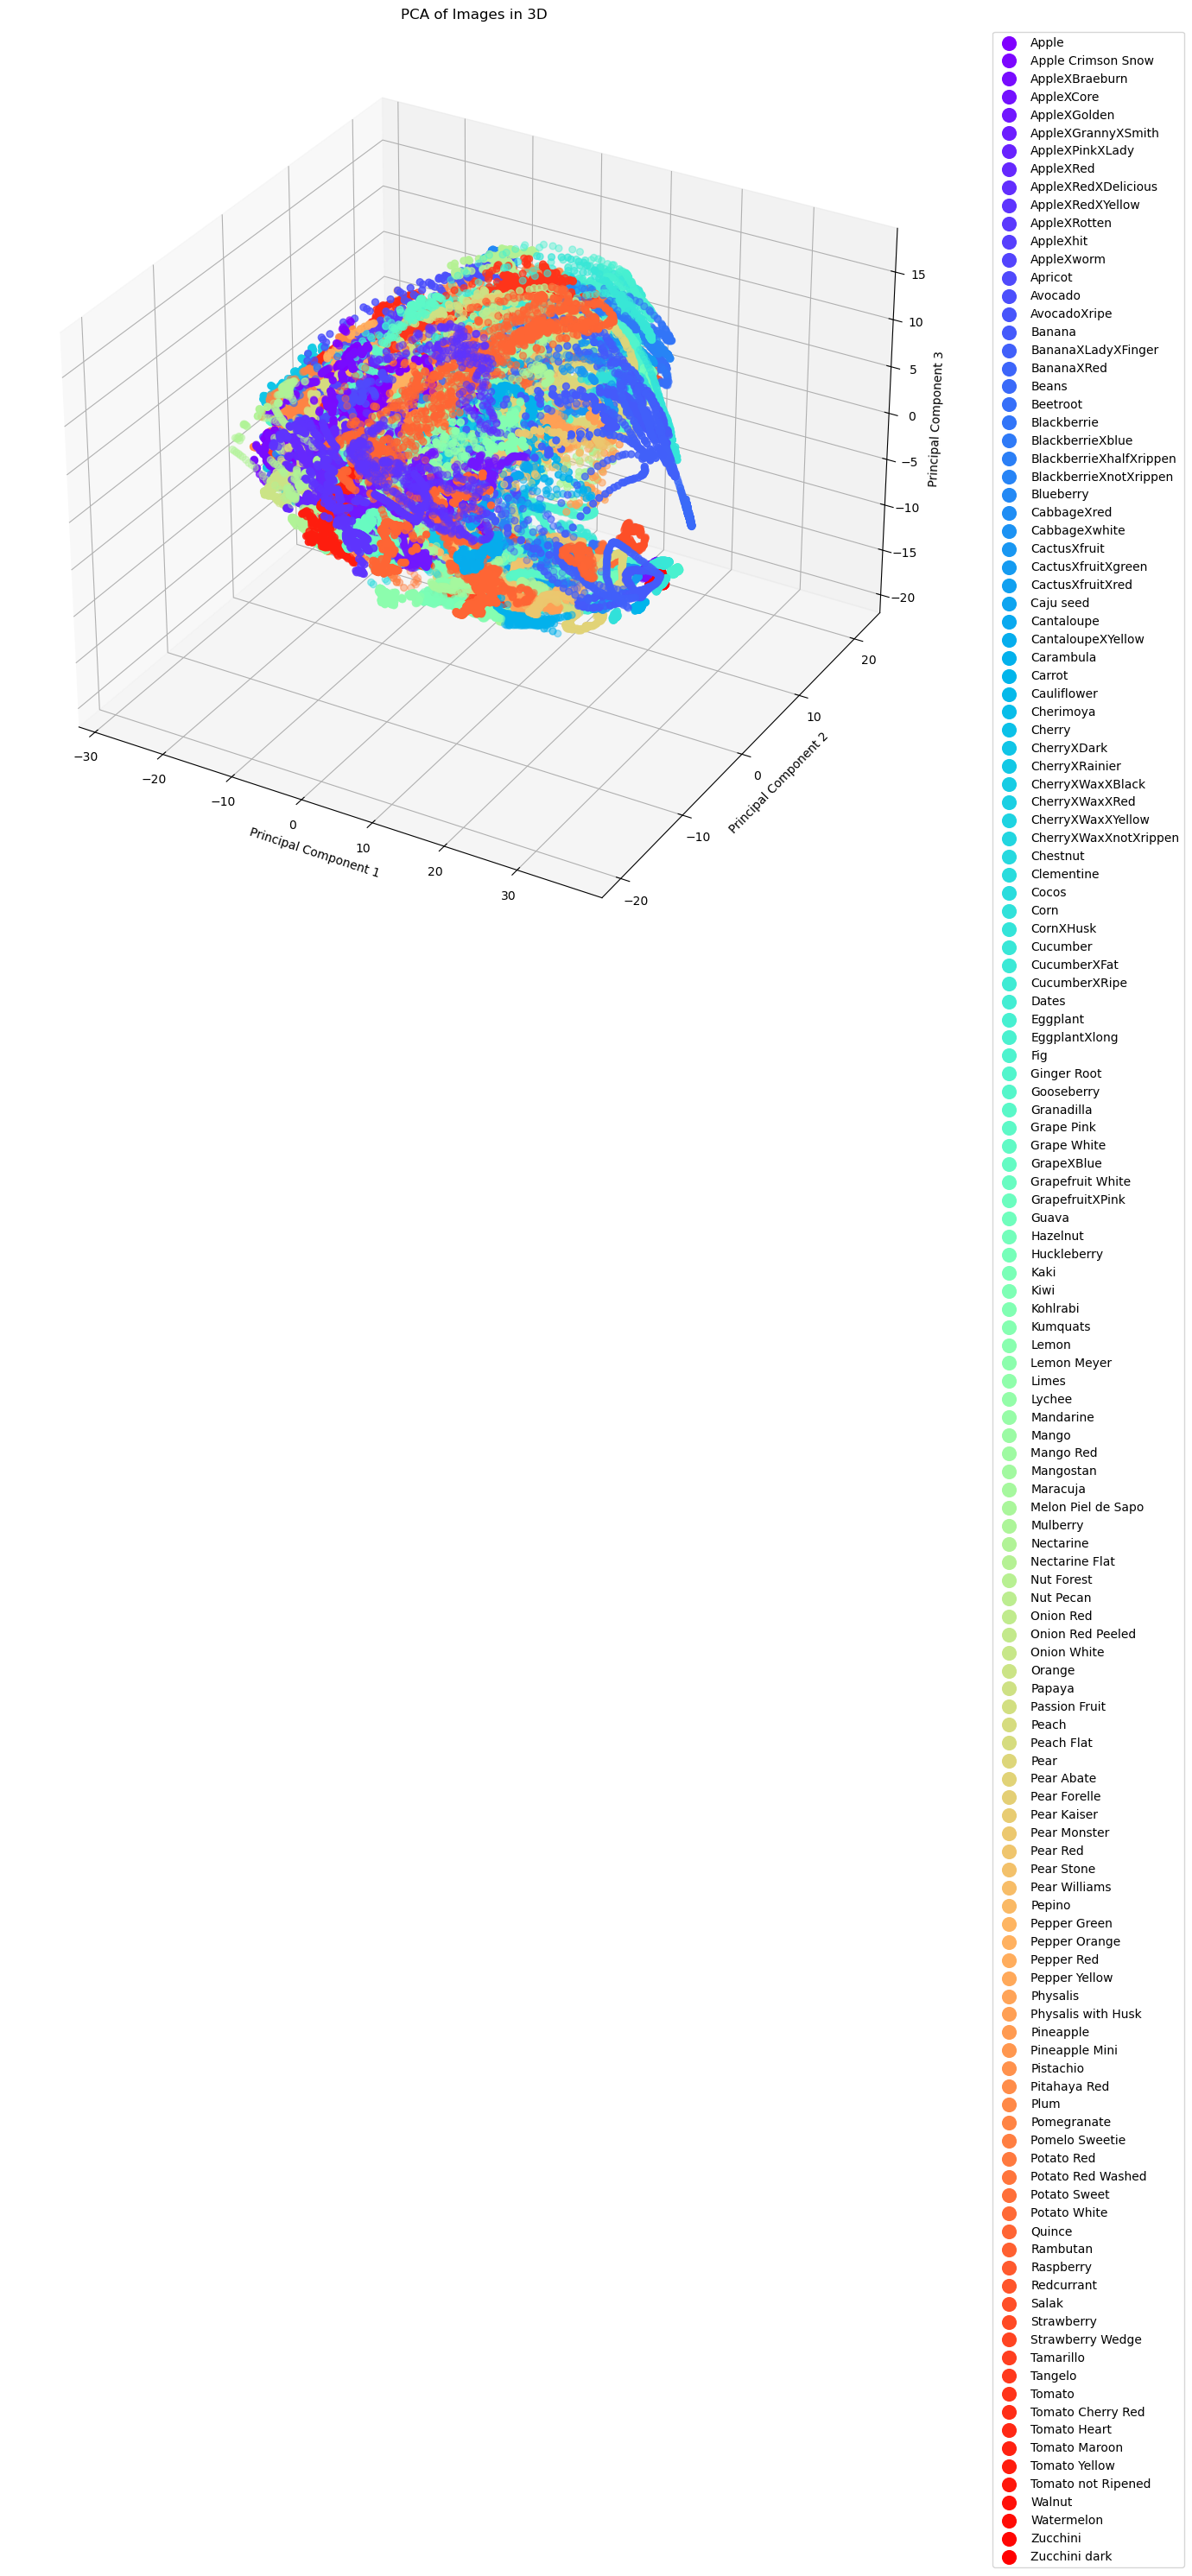

In [ ]:
# this code will do PCA on images like code above and with n_components = 3 
# and visualize the results in 3D
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from matplotlib.widgets import Button  # For adding interactive buttons
def visualize_pca_3d(reduced_images, labels):
    """
    Visualizes the PCA results in a 3D scatter plot.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        labels (np.ndarray): Corresponding labels for the images.
    """
    
    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i
        ax.scatter(reduced_images[mask, 0], reduced_images[mask, 1], reduced_images[mask, 2], label=label, s=32, color=colormap(i / len(unique_labels)))
    
    ax.set_title('PCA of Images in 3D')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Enable interactive rotation and zoom
    plt.tight_layout()
    plt.ion()  # Turn on interactive mode
# Main function to execute the script   
def main_3d():
    """
    Main function to execute the PCA pipeline: importing images, applying PCA, and visualizing results in 3D.
    """
    path = 'fruits-360/Training'  # Path to the dataset
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    # Apply Incremental PCA and visualize the results
    reduced_images, labels = apply_incremental_pca(path, n_components=3, resize_dim=(50, 50), batch_size=1000)
    visualize_pca_3d(reduced_images, labels)
# Entry point of the script
if __name__ == "__main__":
    main_3d()


Loading cached PCA results from cache/pca_3_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 191.12file/s]

Applying KMeans with 140 clusters...


KMeans clustering completed.
Visualizing KMeans clustering results in 3D...


/tmp/ipykernel_35633/1274420620.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))


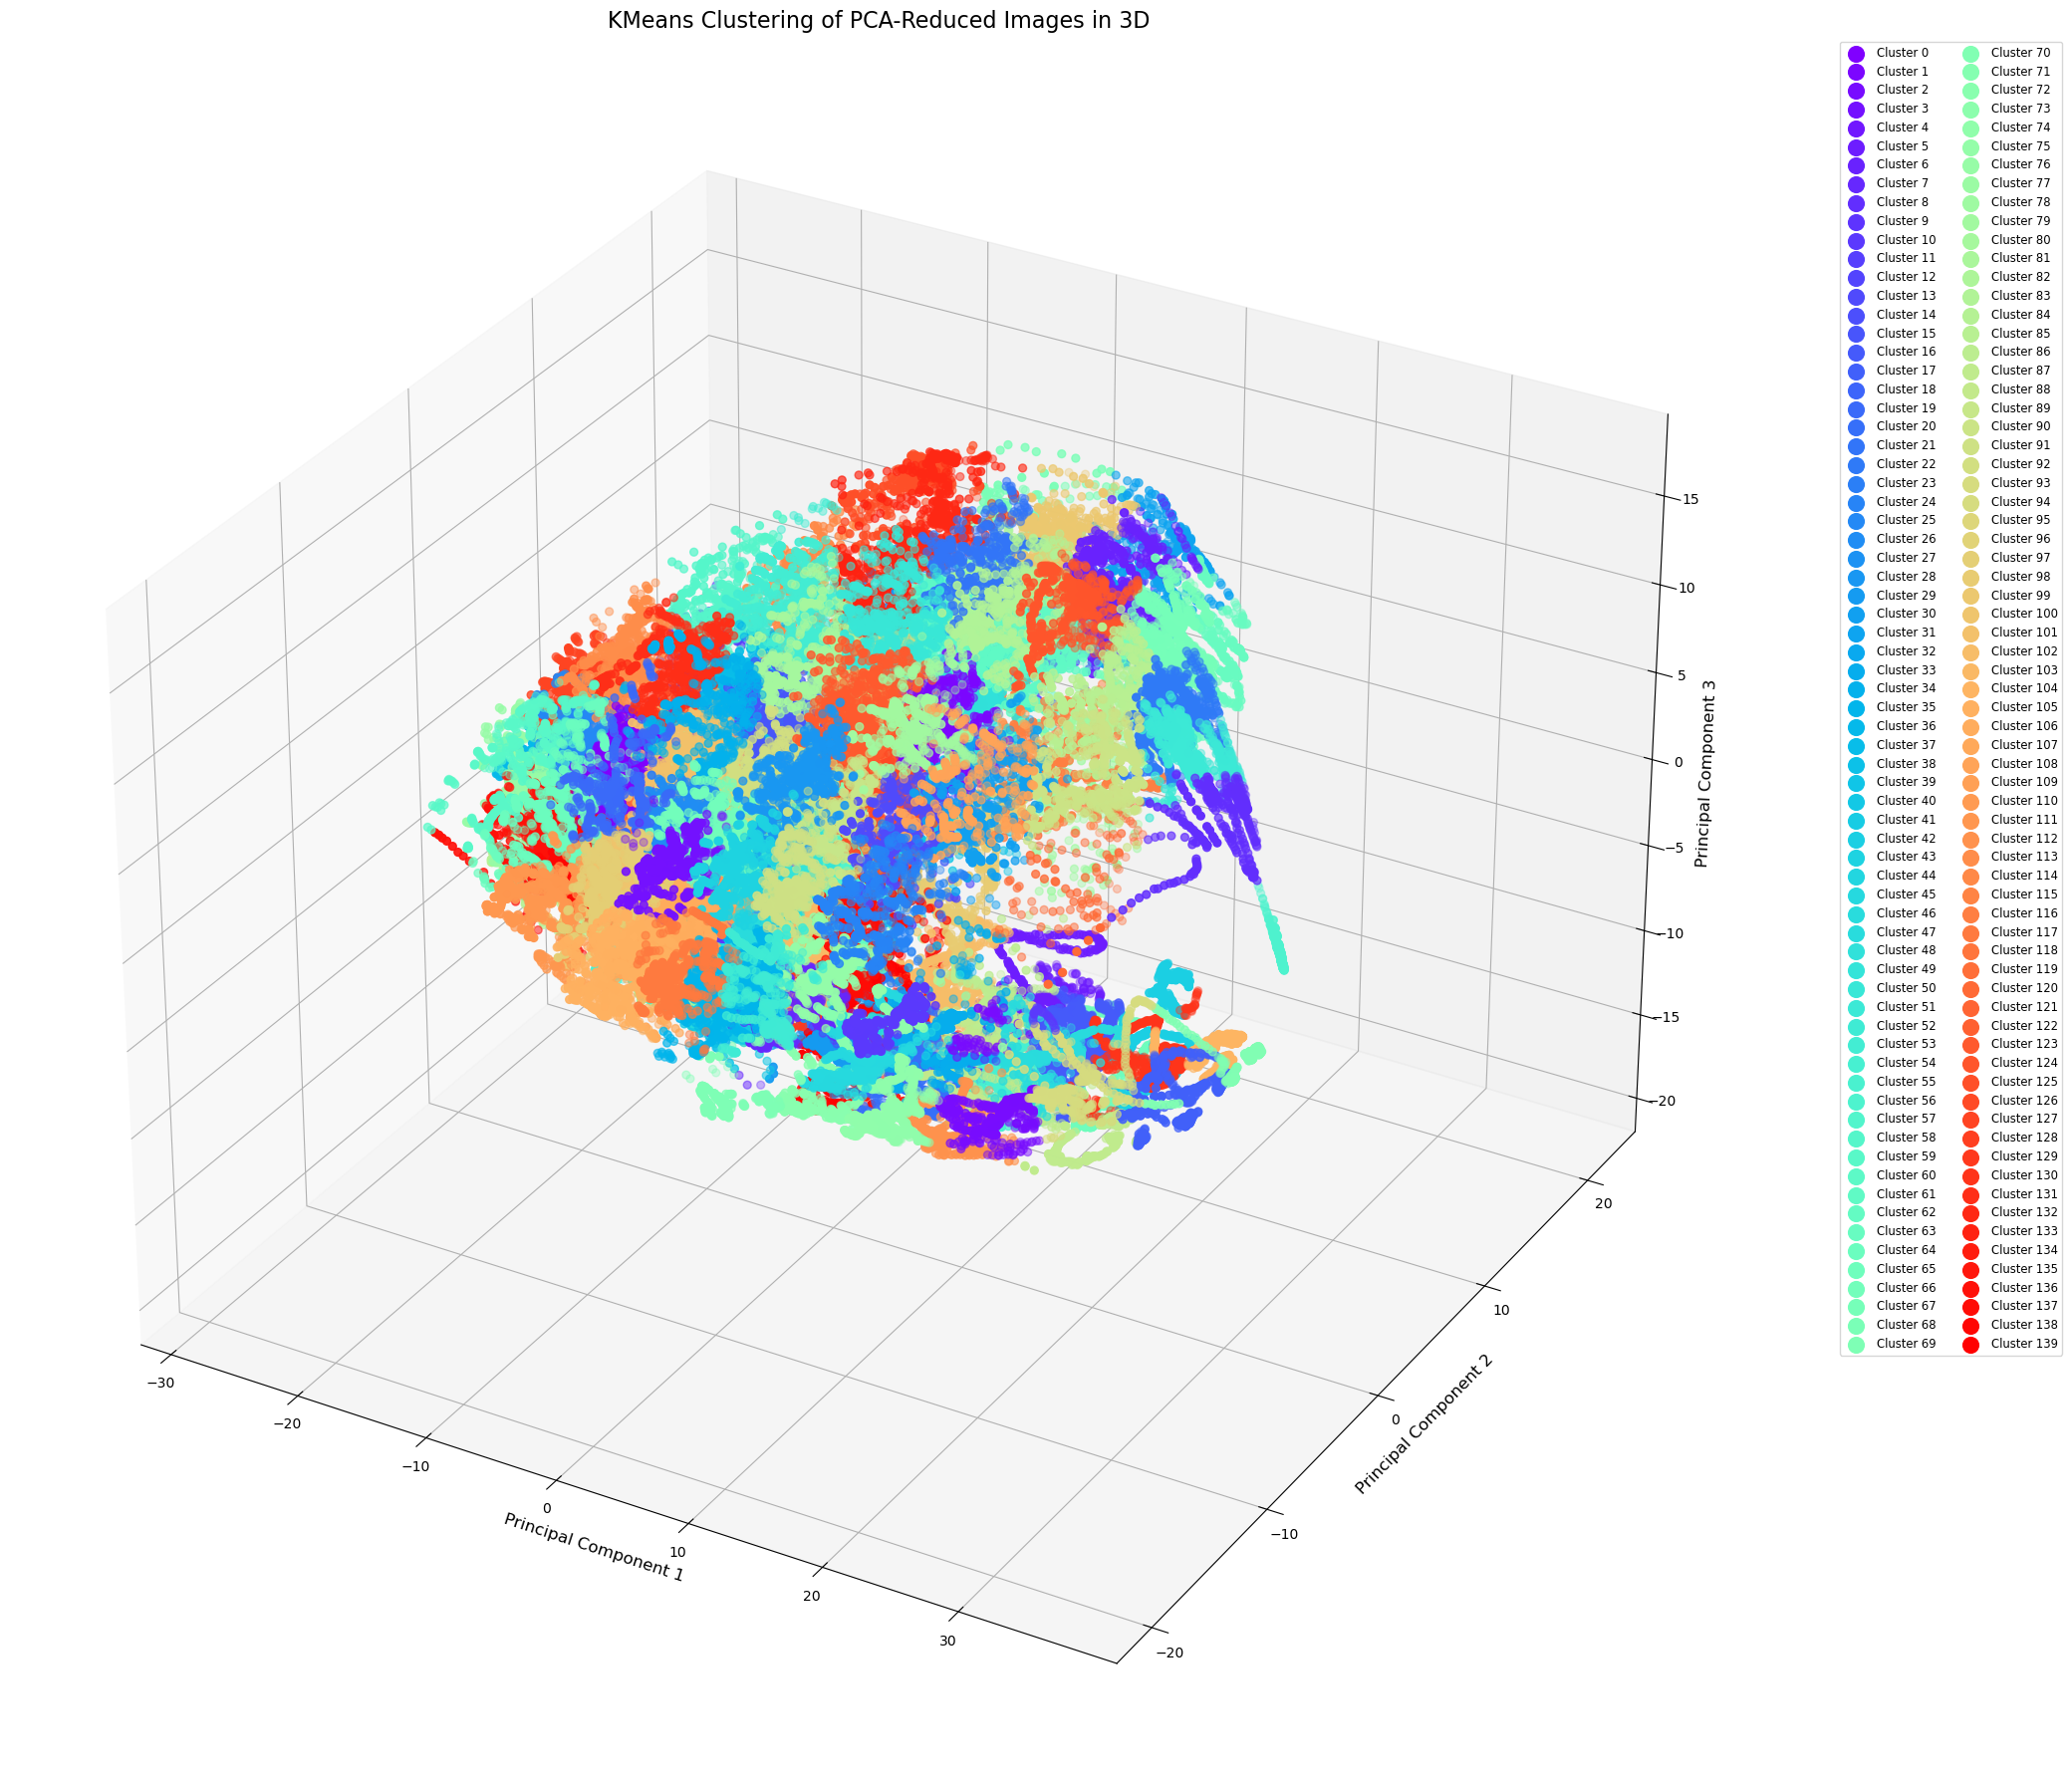

Visualization completed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import os
import pickle
from n import *

def apply_kmeans(reduced_images, n_clusters=140):
    """
    Applies KMeans clustering to the PCA-reduced images.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        np.ndarray: Cluster labels for each data point.
    """
    print(f"Applying KMeans with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Initialize KMeans
    cluster_labels = kmeans.fit_predict(reduced_images)  # Fit and predict cluster labels
    print("KMeans clustering completed.")
    return cluster_labels


def visualize_kmeans_3d(reduced_images, cluster_labels):
    """
    Visualizes the KMeans clustering results in a 3D scatter plot.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        cluster_labels (np.ndarray): Cluster labels for each data point.
    """
    print("Visualizing KMeans clustering results in 3D...")
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique cluster labels and assign colors
    unique_labels = np.unique(cluster_labels)
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    
    # Plot each cluster in the 3D scatter plot
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        ax.scatter(
            reduced_images[mask, 0], 
            reduced_images[mask, 1], 
            reduced_images[mask, 2], 
            label=f'Cluster {label}', 
            s=32, 
            color=colormap(i / len(unique_labels))
        )
    
    # Set plot titles and labels
    ax.set_title('KMeans Clustering of PCA-Reduced Images in 3D', fontsize=16)
    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)
    ax.set_zlabel('Principal Component 3', fontsize=12)
    
    # Add legend
    ax.legend(
        markerscale=2, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        fontsize='small', 
        ncol=2  # Split legend into 2 columns for better readability
    )
    
    plt.tight_layout()
    plt.show()
    print("Visualization completed.")


# Main function for KMeans
def main_kmeans():
    """
    Main function to execute the PCA pipeline and apply KMeans clustering.
    """
    path = 'fruits-360/Training'
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    model_dir = "/home/user/.codeoss-cloudworkstations/model"
    os.makedirs(model_dir, exist_ok=True)
    
    feature_types = ['pixel_intensity', 'color_histogram', 'hog', 'cnn']

    for feature_type in feature_types:
        print(f"\nProcessing feature type with KMeans: {feature_type}")
        for i in range(29,141):
            n_components = i
            # Step 1: Apply PCA
            reduced_images, labels = apply_incremental_pca(
                path, 
                n_components=n_components,  # use 3 for 3D visualization
                resize_dim=(50, 50), 
                batch_size=1000,
                feature_type=feature_type
            )

            # Step 2: Apply KMeans
            cluster_labels = apply_kmeans(reduced_images, n_clusters=140)  # Adjust cluster count

            # Step 3: Save KMeans model
            kmeans_model_path = f"{model_dir}/{feature_type}_{n_components}_kmeans.pkl"
            with open(kmeans_model_path, 'wb') as f:
                pickle.dump(cluster_labels, f)
            print(f"Saved KMeans model to {kmeans_model_path}")

            # Step 4: Visualize clustering (assuming 3D plot)
        visualize_kmeans_3d(reduced_images, cluster_labels, save_path=f"{model_dir}/{feature_type}/{n_components}_kmeans_plot.png")



# Entry point of the script
if __name__ == "__main__":
    main_kmeans()

In [ ]:
# write a code to show a pca file which is in pickle module
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
def load_pca_file(pca_file):
    """
    Load PCA-reduced data from a pickle file.

    Args:
        pca_file (str): Path to the PCA pickle file.

    Returns:
        tuple: PCA-reduced images and their corresponding labels.
    """
    with open(pca_file, 'rb') as f:
        reduced_images, labels = pickle.load(f)
    return reduced_images, labels
def visualize_pca_3d(reduced_images, labels):
    """
    Visualizes the PCA results in a 3D scatter plot.
    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        labels (np.ndarray): Corresponding labels for the images.
    """ 
    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i
        ax.scatter(reduced_images[mask, 0], reduced_images[mask, 1], reduced_images[mask, 2], label=label, s=32, color=colormap(i / len(unique_labels)))
    
    ax.set_title('PCA of Images in 3D')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
# Main function to execute the script   
def main():
    """
    Main function to execute the PCA visualization pipeline.
    """
    pca_file = 'path_to_your_pca_file.pkl'  # Replace with your PCA file path
    if not os.path.exists(pca_file):
        print(f"Error: PCA file '{pca_file}' does not exist.")
        return
    
    # Load PCA data
    reduced_images, labels = load_pca_file(pca_file)
    
    # Visualize PCA results
    visualize_pca_3d(reduced_images, labels)

In [ ]:
# write similar code to extract model.pkl which has cluster labels
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def load_kmeans_file(kmeans_file):
    """
    Load KMeans clustering results from a pickle file.

    Args:
        kmeans_file (str): Path to the KMeans pickle file.

    Returns:
        np.ndarray: Cluster labels for each data point.
    """
    with open(kmeans_file, 'rb') as f:
        cluster_labels = pickle.load(f)
    return cluster_labels
def visualize_kmeans_3d(reduced_images, cluster_labels):
    """
    Visualizes the KMeans clustering results in a 3D scatter plot.  
    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        cluster_labels (np.ndarray): Cluster labels for each data point.
    """
    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(cluster_labels)
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        ax.scatter(reduced_images[mask, 0], reduced_images[mask, 1], reduced_images[mask, 2], label=f'Cluster {label}', s=32, color=colormap(i / len(unique_labels)))
    
    ax.set_title('KMeans Clustering of PCA-Reduced Images in 3D')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
# Main function to execute the script
def main():
    """
    Main function to execute the KMeans visualization pipeline.
    """
    kmeans_file = 'path_to_your_kmeans_file.pkl'  # Replace with your KMeans file path
    if not os.path.exists(kmeans_file):
        print(f"Error: KMeans file '{kmeans_file}' does not exist.")
        return
    
    # Load KMeans data
    cluster_labels = load_kmeans_file(kmeans_file)
    
    # Load PCA data (assuming you have a separate PCA file)
    pca_file = 'path_to_your_pca_file.pkl'  # Replace with your PCA file path
    reduced_images, _ = load_pca_file(pca_file)
    
    # Visualize KMeans results
    visualize_kmeans_3d(reduced_images, cluster_labels)
if __name__ == "__main__":
    main()

In [ ]:
# open a pickle file and show the data in it
import pickle
import os
def load_pickle_file(pickle_file):
    """
    Load data from a pickle file.

    Args:
        pickle_file (str): Path to the pickle file.

    Returns:
        object: Data loaded from the pickle file.
    """
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    return data
def main():
    """
    Main function to execute the pickle file loading and display.
    """
    pickle_file = '/home/lalit-mohan/clustering_results_20250411_223025.pkl'  # Replace with your pickle file path
    if not os.path.exists(pickle_file):
        print(f"Error: Pickle file '{pickle_file}' does not exist.")
        return
    
    # Load data from the pickle file
    data = load_pickle_file(pickle_file)
    
    # Display the loaded data
    print("Data loaded from pickle file:")
    print(data)
if __name__ == "__main__":
    main()

Data loaded from pickle file:
{'cnn': {7: {'silhouette': 0.22423252870379934, 'time': 16.539634227752686, 'samples': 10000}, 2: {'silhouette': 0.3327330173029157, 'time': 17.46146845817566, 'samples': 10000}, 6: {'silhouette': 0.21947006275589676, 'time': 18.403590202331543, 'samples': 10000}, 4: {'silhouette': 0.24031488892734243, 'time': 19.264854192733765, 'samples': 10000}, 3: {'silhouette': 0.26673100998134464, 'time': 19.577960729599, 'samples': 10000}, 5: {'silhouette': 0.22996364145128773, 'time': 19.97206687927246, 'samples': 10000}, 8: {'silhouette': 0.21307541582587042, 'time': 20.23918867111206, 'samples': 10000}, 11: {'silhouette': 0.20245073074974498, 'time': 3.7811193466186523, 'samples': 10000}, 9: {'silhouette': 0.2086407521043323, 'time': 6.880468130111694, 'samples': 10000}, 10: {'silhouette': 0.20340219315136102, 'time': 7.016939401626587, 'samples': 10000}, 13: {'silhouette': 0.19527970275143547, 'time': 6.39992356300354, 'samples': 10000}, 12: {'silhouette': 0.204

image predictor

In [ ]:
import pickle
import os
import numpy as np
from sklearn.metrics import silhouette_score
import cv2
from skimage.feature import hog
from sklearn.decomposition import PCA
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

class ImageClusterPredictor:
    def __init__(self, model_dir, pca_dir, feature_type='hog', n_components=51):
        """Initialize predictor with paths to model and PCA files.
        
        Args:
            model_dir (str): Directory containing KMeans models
            pca_dir (str): Directory containing PCA transformations
            feature_type (str): Type of features ('hog', 'cnn', 'color_histogram', 'pixel_intensity')
            n_components (int): Number of PCA components used
        """
        self.feature_type = feature_type
        self.n_components = n_components
        
        # Load VGG16 model if using CNN features
        if feature_type == 'cnn':
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
            self.cnn_model = Model(inputs=base_model.input, outputs=base_model.output)
        
        # Load model and PCA
        self.kmeans = self._load_kmeans(model_dir)
        self.pca = self._load_pca(pca_dir)

    def _load_kmeans(self, model_dir):
        """Load KMeans model from pickle file"""
        model_path = os.path.join(model_dir, f"{self.feature_type}_{self.n_components}_kmeans.pkl")
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"KMeans model not found at {model_path}")
        with open(model_path, 'rb') as f:
            return pickle.load(f)

    def _load_pca(self, pca_dir):
        """Load PCA transformation from pickle file"""
        pca_path = os.path.join(pca_dir, f"pca_{self.feature_type}_{self.n_components}_components.pkl")
        if not os.path.exists(pca_path):
            raise FileNotFoundError(f"PCA file not found at {pca_path}")
        with open(pca_path, 'rb') as f:
            pca_data = pickle.load(f)
            if isinstance(pca_data, tuple):
                return pca_data[0]  # Assuming first element is the PCA object
            return pca_data

    def extract_color_histogram(self, image, bins=8):
        """Extracts a color histogram from the image.
        
        Args:
            image (np.ndarray): Input image.
            bins (int): Number of bins for the histogram.
            
        Returns:
            np.ndarray: Color histogram features.
        """
        hist = cv2.calcHist([image], [0, 1, 2], None, [bins]*3, [0, 256]*3)
        hist = cv2.normalize(hist, hist).flatten()
        return hist

    def extract_hog_features(self, image):
        """Extracts HOG features from the image.
        
        Args:
            image (np.ndarray): Input image.
            
        Returns:
            np.ndarray: HOG features.
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        return features

    def extract_cnn_features(self, image):
        """Extracts CNN features from the image using a pre-trained VGG16 model.
        
        Args:
            image (np.ndarray): Input image.
            
        Returns:
            np.ndarray: CNN features.
        """
        # Resize image to 50x50 if needed
        if image.shape[:2] != (50, 50):
            image = cv2.resize(image, (50, 50))
        
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        features = self.cnn_model.predict(image)
        return features.flatten()

    def extract_features(self, image):
        """Extract features from image based on feature_type.
        
        Args:
            image (numpy.ndarray): Input image (BGR format)
            
        Returns:
            numpy.ndarray: Extracted features
        """
        # Convert to RGB if needed
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.feature_type == 'hog':
            return self.extract_hog_features(image)
        elif self.feature_type == 'cnn':
            return self.extract_cnn_features(image)
        elif self.feature_type == 'color_histogram':
            return self.extract_color_histogram(image)
        elif self.feature_type == 'pixel_intensity':
            return image.flatten()
        else:
            raise ValueError(f"Unsupported feature type: {self.feature_type}")

    def predict(self, image):
        """Predict cluster for a single image.
        
        Args:
            image (numpy.ndarray): Input image (BGR format)
            
        Returns:
            int: Predicted cluster label
        """
        # 1. Extract features
        features = self.extract_features(image)
        
        # 2. Apply PCA transformation
        if hasattr(self.pca, 'transform'):
            # PCA object with transform method
            reduced_features = self.pca.transform([features])
        else:
            # PCA matrix (assuming it's the transformation matrix)
            reduced_features = np.dot([features], self.pca.T)
        
        # 3. Predict cluster
        if hasattr(self.kmeans, 'predict'):
            # KMeans object with predict method
            return self.kmeans.predict(reduced_features)[0]
        else:
            # Cluster labels array (nearest centroid)
            distances = np.linalg.norm(reduced_features - self.kmeans.cluster_centers_, axis=1)
            return np.argmin(distances)

    def batch_predict(self, images):
        """Predict clusters for multiple images.
        
        Args:
            images (list of numpy.ndarray): List of input images
            
        Returns:
            numpy.ndarray: Array of predicted cluster labels
        """
        # Extract features for all images
        features = [self.extract_features(img) for img in images]
        
        # Apply PCA transformation
        if hasattr(self.pca, 'transform'):
            reduced_features = self.pca.transform(features)
        else:
            reduced_features = np.dot(features, self.pca.T)
        
        # Predict clusters
        if hasattr(self.kmeans, 'predict'):
            return self.kmeans.predict(reduced_features)
        else:
            distances = np.linalg.norm(reduced_features[:, np.newaxis] - self.kmeans.cluster_centers_, axis=2)
            return np.argmin(distances, axis=1)

def main():
    # Initialize predictor
    predictor = ImageClusterPredictor(
        model_dir='/home/user/.codeoss-cloudworkstations/model',
        pca_dir='/home/user/.codeoss-cloudworkstations/cache',
        feature_type='hog',  # Can be 'hog', 'cnn', 'color_histogram', or 'pixel_intensity'
        n_components=51
    )
    
    # Example usage with a test image
    test_image = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)  # Replace with actual image
    
    # Single prediction
    cluster = predictor.predict(test_image)
    print(f"Predicted cluster: {cluster}")
    
    # Batch prediction
    test_images = [np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8) for _ in range(5)]
    clusters = predictor.batch_predict(test_images)
    print(f"Batch predicted clusters: {clusters}")

if __name__ == "__main__":
    main()

model_tester

In [ ]:
import pickle
import os
import numpy as np
from sklearn.metrics import silhouette_score

def load_kmeans_file(kmeans_file):
    """
    Load KMeans clustering results from a pickle file.
    Args:
        kmeans_file (str): Path to the KMeans pickle file.
    Returns:
        np.ndarray: Cluster labels for each data point.
    """
    with open(kmeans_file, 'rb') as f:
        cluster_labels = pickle.load(f)
    return cluster_labels

def load_pca_file(pca_file):
    """
    Load PCA-reduced data from a pickle file.
    Args:
        pca_file (str): Path to the PCA pickle file.
    Returns:
        np.ndarray: PCA-reduced images (and optionally labels).
    """
    with open(pca_file, 'rb') as f:
        reduced_images, _ = pickle.load(f)
    return reduced_images

def main():
    """
    Main function to load PCA and KMeans files and compute silhouette score.
    """
    kmeans_file = '/home/user/.codeoss-cloudworkstations/model/hog_51_kmeans.pkl'  # Replace with your KMeans file path
    pca_file = 'pca_hog_51_components.pkl'  # Replace with your PCA file path

    if not os.path.exists(kmeans_file):
        print(f"Error: KMeans file '{kmeans_file}' does not exist.")
        return
    if not os.path.exists(pca_file):
        print(f"Error: PCA file '{pca_file}' does not exist.")
        return

    # Load data
    cluster_labels = load_kmeans_file(kmeans_file)
    reduced_images = load_pca_file(pca_file)

    # Compute silhouette score
    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(reduced_images, cluster_labels)
        print(f"Silhouette Score (51 components): {score:.4f}")
    else:
        print("Silhouette Score cannot be calculated: only one cluster detected.")

if __name__ == "__main__":
    main()
